# RECSYS COMPETITION - 1st place

In [3]:
LOAD_MODELS = False

# Importing the repo

In [4]:
import os

os.chdir( "../")

In [5]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import scipy.sparse as sps
import csv
from tqdm import tqdm

from Recommenders.Recommender_import_list import *

2024-01-10 14:58:26.960025: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-01-10 14:58:26.960065: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## Data Import and Preprocessing

Import dataframes

In [6]:
data_train_path = "Dataset/data_train.csv"
data_test_path = "Dataset/data_target_users_test.csv"

In [7]:
df = pd.read_csv(data_train_path)
df_test = pd.read_csv(data_test_path)

df.columns = ["UserID", "ItemID", "Interaction"]
df_test.columns = ["UserID"]

In [8]:
metric_to_optimize="MAP"
cutoff_to_optimize=10

In [9]:
user_ids = df["UserID"].unique().tolist()
user2user_encoded = {x: i for i, x in enumerate(user_ids)}
userencoded2user = {i: x for i, x in enumerate(user_ids)}
item_ids = df["ItemID"].unique().tolist()
item2item_encoded = {x: i for i, x in enumerate(item_ids)}
item_encoded2item = {i: x for i, x in enumerate(item_ids)}
df["User"] = df["UserID"].map(user2user_encoded)
df["Item"] = df["ItemID"].map(item2item_encoded)

num_users = len(user2user_encoded)
num_items = len(item_encoded2item)
df["Interaction"] = df["Interaction"].values.astype(np.float32)

# min and max ratings will be used to normalize the ratings later
min_rating = 0.0
max_rating = max(df["Interaction"])

print(
    "Number of users: {}, Number of Items: {}, Min rating: {}, Max rating: {}".format(
        num_users, num_items, min_rating, max_rating
    )
)

Number of users: 12638, Number of Items: 22222, Min rating: 0.0, Max rating: 1.0


In [10]:
userId_unique = df["UserID"].unique()
itemId_unique = df["ItemID"].unique()

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, KFold
import numpy as np
import scipy.sparse as sps
from Data_manager.split_functions.split_train_validation_random_holdout import split_train_in_two_percentage_global_sample


urm_all = sps.coo_matrix((df["Interaction"].values, 
                          (df["User"].values, df["Item"].values)))


urm_train_validation, urm_test = split_train_in_two_percentage_global_sample(urm_all, train_percentage = 0.80,seed=654)
urm_train, urm_validation = split_train_in_two_percentage_global_sample(urm_train_validation, train_percentage = 0.80,seed=654)




In [12]:
from Evaluation.Evaluator import EvaluatorHoldout

evaluator_validation = EvaluatorHoldout(urm_validation, cutoff_list=[10])
evaluator_test = EvaluatorHoldout(urm_test, cutoff_list=[10])

EvaluatorHoldout: Ignoring 2665 (21.1%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 2170 (17.2%) Users that have less than 1 test interactions


# Models

Fitting the hybrid

In [13]:
from Recommenders.SLIM.SLIMElasticNetRecommender import MultiThreadSLIM_SLIMElasticNetRecommender

In [14]:
slimen4rec = MultiThreadSLIM_SLIMElasticNetRecommender(urm_train_validation)
slimen4rec.fit(workers=8, **{'alpha': 0.005845967797646911, 'l1_ratio': 0.00013811515012747763, 'topK': 1610})


SLIMElasticNetRecommender: URM Detected 226 ( 1.8%) users with no interactions.
SLIMElasticNetRecommender: URM Detected 114 ( 0.5%) items with no interactions.


  0%|          | 0/22222 [00:00<?, ?it/s]

100%|█████████▉| 22216/22222 [00:55<00:00, 401.04it/s]


In [15]:
rp34rec = RP3betaRecommender(urm_train_validation)
rp34rec.fit(**{'topK': 122, 'alpha': 0.2522633066202722, 'beta': 0.19615409165027764})

RP3betaRecommender: URM Detected 226 ( 1.8%) users with no interactions.
RP3betaRecommender: URM Detected 114 ( 0.5%) items with no interactions.
RP3betaRecommender: Similarity column 22222 (100.0%), 5388.50 column/sec. Elapsed time 4.12 sec


In [16]:
from Recommenders.KNN.ItemKNNSimilarityHybridRecommender import ItemKNNSimilarityHybridRecommender


hybrid4gb = ItemKNNSimilarityHybridRecommender(urm_train_validation, slimen4rec.W_sparse, rp34rec.W_sparse)
hybrid4gb.fit(**{'alpha': 0.2312897980071662, 'topK': 8210})

ItemKNNSimilarityHybridRecommender: URM Detected 226 ( 1.8%) users with no interactions.
ItemKNNSimilarityHybridRecommender: URM Detected 114 ( 0.5%) items with no interactions.


In [21]:
slimen4recTrain = MultiThreadSLIM_SLIMElasticNetRecommender(urm_train)
slimen4recTrain.fit(workers=8, **{'alpha': 0.005845967797646911, 'l1_ratio': 0.00013811515012747763, 'topK': 1610})


SLIMElasticNetRecommender: URM Detected 474 ( 3.8%) users with no interactions.
SLIMElasticNetRecommender: URM Detected 340 ( 1.5%) items with no interactions.


100%|█████████▉| 22216/22222 [00:51<00:00, 427.42it/s]


In [22]:
rp34recTrain = RP3betaRecommender(urm_train)
rp34recTrain.fit(**{'topK': 122, 'alpha': 0.2522633066202722, 'beta': 0.19615409165027764})

RP3betaRecommender: URM Detected 474 ( 3.8%) users with no interactions.
RP3betaRecommender: URM Detected 340 ( 1.5%) items with no interactions.
RP3betaRecommender: Similarity column 22222 (100.0%), 6994.17 column/sec. Elapsed time 3.18 sec


In [24]:
from Recommenders.KNN.ItemKNNSimilarityHybridRecommender import ItemKNNSimilarityHybridRecommender


hybrid4gbTrain = ItemKNNSimilarityHybridRecommender(urm_train, slimen4recTrain.W_sparse, rp34recTrain.W_sparse)
hybrid4gbTrain.fit(**{'alpha': 0.2312897980071662, 'topK': 8210})

ItemKNNSimilarityHybridRecommender: URM Detected 474 ( 3.8%) users with no interactions.
ItemKNNSimilarityHybridRecommender: URM Detected 340 ( 1.5%) items with no interactions.


## XGBoost

In [74]:
import pandas as pd
import scipy.sparse as sps
import numpy as np

### First, we prepare the df for the training

In [75]:
cutoff = 20

In [76]:
n_users, n_items = urm_train.shape

training_dataframe = pd.DataFrame(index=range(0,n_users), columns = ["ItemID"])
training_dataframe.index.name='UserID'

candidate_generator_recommender = hybrid4gb

In [77]:
for user_id in tqdm(range(n_users)):    
    recommendations = candidate_generator_recommender.recommend(user_id, cutoff = cutoff)
    training_dataframe.loc[user_id, "ItemID"] = recommendations

training_dataframe = training_dataframe.explode("ItemID")

100%|██████████| 12638/12638 [00:06<00:00, 2013.84it/s]


In [78]:
urm_validation_coo = sps.coo_matrix(urm_test)

correct_recommendations = pd.DataFrame({"UserID": urm_validation_coo.row,
                                        "ItemID": urm_validation_coo.col})

training_dataframe = pd.merge(training_dataframe, correct_recommendations, on=['UserID','ItemID'], how='left', indicator='Exist')

training_dataframe["Label"] = training_dataframe["Exist"] == "both"
training_dataframe.drop(columns = ['Exist'], inplace=True)
training_dataframe

,UserID,ItemID,Label
0,0,674,False
1,0,587,False
2,0,1118,False
3,0,1585,False
4,0,2755,False
...,...,...,...
252755,12637,13158,False
252756,12637,10905,False
252757,12637,689,False
252758,12637,327,False


In [79]:
slimen4map = MultiThreadSLIM_SLIMElasticNetRecommender(urm_train_validation)
slimen4map.fit(workers=8,**{'alpha':0.0008361537677496276,'topK':3334, 'l1_ratio':0.09976758088492818})

rp34map = RP3betaRecommender(urm_train_validation)
rp34map.fit(**{'topK': 29, 'alpha': 0.33723025040409343, 'beta': 0.15542352567862933, 'normalize_similarity': True})

itemknn4map = ItemKNNCFRecommender(urm_train_validation)
itemknn4map.fit(**{'topK': 19, 'shrink': 28, 'similarity': 'tversky', 'normalize': True, 'tversky_alpha': 0.0, 'tversky_beta': 1.3672226785339947})

hybrid4map = ItemKNNSimilarityHybridRecommender(urm_train_validation, rp34map.W_sparse, slimen4map.W_sparse)
hybrid4map.fit(**{'topK': 1000, 'alpha': 0.484326762079027})




SLIMElasticNetRecommender: URM Detected 226 ( 1.8%) users with no interactions.
SLIMElasticNetRecommender: URM Detected 114 ( 0.5%) items with no interactions.


100%|█████████▉| 22216/22222 [00:39<00:00, 562.50it/s]


RP3betaRecommender: URM Detected 226 ( 1.8%) users with no interactions.
RP3betaRecommender: URM Detected 114 ( 0.5%) items with no interactions.
RP3betaRecommender: Similarity column 22222 (100.0%), 7500.52 column/sec. Elapsed time 2.96 sec
ItemKNNCFRecommender: URM Detected 226 ( 1.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 114 ( 0.5%) items with no interactions.
Similarity column 22222 (100.0%), 11826.09 column/sec. Elapsed time 1.88 sec


**We add features to the df:**
- first we train some models
- then we add their computed scores to the XGB Train Df

In [80]:
hybrid4map = ItemKNNSimilarityHybridRecommender(urm_train_validation, rp34map.W_sparse, slimen4map.W_sparse)
hybrid4map.fit(**{'topK': 1000, 'alpha': 0.484326762079027})

ItemKNNSimilarityHybridRecommender: URM Detected 226 ( 1.8%) users with no interactions.
ItemKNNSimilarityHybridRecommender: URM Detected 114 ( 0.5%) items with no interactions.


In [81]:
from Recommenders.MatrixFactorization.ImplicitIALSRecommender import ImplicitALSRecommender


ials_train = ImplicitALSRecommender(urm_train_validation)
ials_train.fit(use_gpu=True, num_threads=1,**{'num_factors': 401, 'reg': 0.0010579931024405477,'epsilon':0.10666578585393433, 'epochs':1204, 'alpha': 7.139858098793055, 'confidence_scaling': 'linear'})

P3Alpha_train = P3alphaRecommender(urm_train_validation)
P3Alpha_train.fit(**{'alpha':0.740243876372529,'topK':41})

other_algorithms = {
    "Hybrid": hybrid4map,
    "SLIM_Elastic": slimen4map,
    "RP3Beta": rp34map,
    "ItemKNN_CFCBF": itemknn4map,
    "IALS": ials_train,
    "P3Alpha": P3Alpha_train,
}

ImplicitALSRecommender: URM Detected 226 ( 1.8%) users with no interactions.
ImplicitALSRecommender: URM Detected 114 ( 0.5%) items with no interactions.
Using gpu: True


  0%|          | 0/1204 [00:00<?, ?it/s]

P3alphaRecommender: URM Detected 226 ( 1.8%) users with no interactions.
P3alphaRecommender: URM Detected 114 ( 0.5%) items with no interactions.
P3alphaRecommender: Similarity column 22222 (100.0%), 8276.53 column/sec. Elapsed time 2.68 sec


In [82]:
training_dataframe = training_dataframe.set_index('UserID')

for user_id in tqdm(range(n_users)):       
    for rec_label, rec_instance in other_algorithms.items():
        
        item_list = training_dataframe.loc[user_id, "ItemID"].values.tolist()
        
        all_item_scores = rec_instance._compute_item_score([user_id], items_to_compute = item_list)

        training_dataframe.loc[user_id, rec_label] = all_item_scores[0, item_list] 

training_dataframe = training_dataframe.reset_index()
training_dataframe = training_dataframe.rename(columns = {"index": "UserID"})
training_dataframe

100%|██████████| 12638/12638 [01:16<00:00, 165.51it/s]


,UserID,ItemID,Label,Hybrid,SLIM_Elastic,RP3Beta,ItemKNN_CFCBF,IALS,P3Alpha
0,0,674,False,0.435069,0.419055,0.452120,1.289657,0.500047,0.247149
1,0,587,False,0.274445,0.272682,0.276323,0.875749,0.283056,0.177016
2,0,1118,False,0.126080,0.153830,0.096535,0.392503,0.536363,0.000000
3,0,1585,False,0.183817,0.201476,0.165015,0.328523,0.546714,0.059414
4,0,2755,False,0.210559,0.259410,0.158546,0.414893,0.401523,0.166751
...,...,...,...,...,...,...,...,...,...
252755,12637,13158,False,0.152550,0.145756,0.159784,0.778349,0.484064,0.112864
252756,12637,10905,False,0.145934,0.109031,0.185226,0.485402,0.505674,0.106177
252757,12637,689,False,0.138816,0.192938,0.081190,0.491295,0.261569,0.000000
252758,12637,327,False,0.210945,0.256969,0.161943,0.570179,0.247393,0.169078


In [83]:
item_popularity = np.ediff1d(sps.csc_matrix(urm_train_validation).indptr)
training_dataframe['item_popularity'] = item_popularity[training_dataframe["ItemID"].values.astype(int)]

user_popularity = np.ediff1d(sps.csr_matrix(urm_train_validation).indptr)
training_dataframe['user_profile_len'] = user_popularity[training_dataframe["UserID"].values.astype(int)]

training_dataframe

,UserID,ItemID,Label,Hybrid,SLIM_Elastic,RP3Beta,ItemKNN_CFCBF,IALS,P3Alpha,item_popularity,user_profile_len
0,0,674,False,0.435069,0.419055,0.452120,1.289657,0.500047,0.247149,358,35
1,0,587,False,0.274445,0.272682,0.276323,0.875749,0.283056,0.177016,567,35
2,0,1118,False,0.126080,0.153830,0.096535,0.392503,0.536363,0.000000,110,35
3,0,1585,False,0.183817,0.201476,0.165015,0.328523,0.546714,0.059414,74,35
4,0,2755,False,0.210559,0.259410,0.158546,0.414893,0.401523,0.166751,111,35
...,...,...,...,...,...,...,...,...,...,...,...
252755,12637,13158,False,0.152550,0.145756,0.159784,0.778349,0.484064,0.112864,10,58
252756,12637,10905,False,0.145934,0.109031,0.185226,0.485402,0.505674,0.106177,10,58
252757,12637,689,False,0.138816,0.192938,0.081190,0.491295,0.261569,0.000000,155,58
252758,12637,327,False,0.210945,0.256969,0.161943,0.570179,0.247393,0.169078,159,58


### Time to train XGBoost

In [84]:
groups = training_dataframe.groupby("UserID").size().values
groups

array([20, 20, 20, ..., 20, 20, 20])

In [96]:
from xgboost import XGBRanker

n_estimators = 125
learning_rate = 0.19823429576094637
reg_alpha = 47
reg_lambda = 100
max_depth = 3
max_leaves = 4
grow_policy = "depthwise"
objective = "pairwise"
booster = "gbtree"
use_user_profile = False
random_seed = None

colsample_bytree = 0.6113704247857885
gamma = 8.964184693722684
min_child_weight = 7.0

XGB_model = XGBRanker(objective='rank:{}'.format(objective),
                      n_estimators = int(n_estimators),
                      random_state = random_seed,
                      learning_rate = learning_rate,
                      reg_alpha = reg_alpha,
                      reg_lambda = reg_lambda,
                      max_depth = int(max_depth),
                      max_leaves = int(max_leaves),
                      grow_policy = grow_policy,
                      verbosity = 0, # 2 if self.verbose else 0,
                      booster = booster,
                      colsample_bytree = colsample_bytree,
                      gamma = gamma,
                      min_child_weight = min_child_weight,
                      tree_method = "hist"
                      )

In [97]:
training_dataframe["ItemID"] = training_dataframe["ItemID"].astype(int)
training_dataframe.dtypes

UserID                int64
ItemID                int64
Label                  bool
Hybrid              float64
SLIM_Elastic        float64
RP3Beta             float64
ItemKNN_CFCBF       float64
IALS                float64
P3Alpha             float64
item_popularity       int32
user_profile_len      int32
dtype: object

In [98]:
X_train = training_dataframe.drop(columns=["Label"])
y_train = training_dataframe["Label"]

XGB_model.fit(X_train,
          y_train,
          group=groups,
          verbose=True)

XGBRanker(base_score=None, booster='gbtree', callbacks=None,
          colsample_bylevel=None, colsample_bynode=None,
          colsample_bytree=0.6113704247857885, device=None,
          early_stopping_rounds=None, enable_categorical=False,
          eval_metric=None, feature_types=None, gamma=8.964184693722684,
          grow_policy='depthwise', importance_type=None,
          interaction_constraints=None, learning_rate=0.19823429576094637,
          max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
          max_delta_step=None, max_depth=3, max_leaves=4, min_child_weight=7.0,
          missing=nan, monotone_constraints=None, multi_strategy=None,
          n_estimators=125, n_jobs=None, num_parallel_tree=None,
          objective='rank:pairwise', ...)

<Axes: title={'center': 'Weight (Frequence)'}, xlabel='F score', ylabel='Features'>

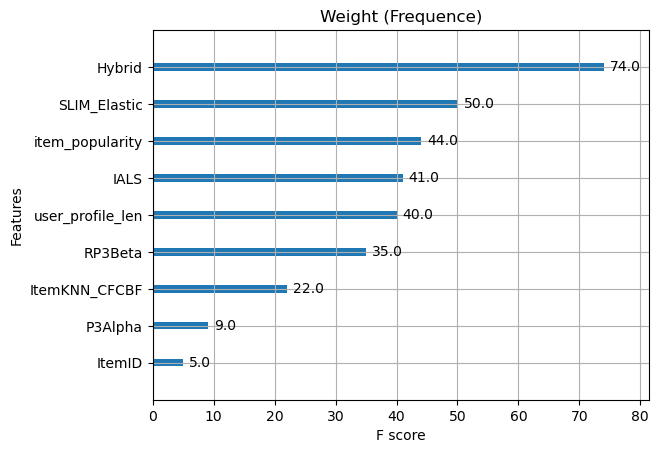

In [99]:
%matplotlib inline
from xgboost import plot_importance
plot_importance(XGB_model, importance_type='weight', title='Weight (Frequence)')

In [103]:
XGB_model.predict(X_train[1:])

array([ 0.88815004, -0.15828136,  0.26386157, ..., -0.41410205,
        0.23580153,  0.30490807], dtype=float32)

In [104]:
from Recommenders.BaseRecommender import BaseRecommender

class XGBoostRecommender(BaseRecommender):

    RECOMMENDER_NAME = "XGBoostRecommender"

    def __init__(self,
                URM_train,
                model,
                X_train
                ):

        super(XGBoostRecommender, self).__init__(URM_train, verbose=True)

        self.XGB_model = model
        self.X_train = X_train
        

    
    def get_URM_train(self):
        return self.URM_train

    def _compute_item_score(self, user_id_array, items_to_compute):
        item_weights = np.zeros((len(user_id_array), self.n_items))
        for i, user in enumerate(user_id_array):
            X_to_predict = self.X_train[self.X_train["UserID"] == user]
            scores = self.XGB_model.predict(X_to_predict)
            scores = (scores - scores.min())/(scores.max() - scores.min() + 1e-12)
            item_weights[i][X_to_predict["ItemID"]] = scores

        return item_weights

In [105]:
xg = XGBoostRecommender(urm_train_validation, XGB_model, X_train)

XGBoostRecommender: URM Detected 226 ( 1.8%) users with no interactions.
XGBoostRecommender: URM Detected 114 ( 0.5%) items with no interactions.


In [106]:
res = xg.recommend(user2user_encoded[2], cutoff=10)

In [107]:
arr = []
for i in res:
    arr.append(item_encoded2item[i])

print(arr)

[1095, 12, 1522, 196, 4, 102, 283, 47, 131, 790]


**ALL**

In [109]:
slimen4rec_all = MultiThreadSLIM_SLIMElasticNetRecommender(urm_all)
slimen4rec_all.fit(workers=8, **{'alpha': 0.005845967797646911, 'l1_ratio': 0.00013811515012747763, 'topK': 1610})


rp34rec_all = RP3betaRecommender(urm_all)
rp34rec_all.fit(**{'topK': 122, 'alpha': 0.2522633066202722, 'beta': 0.19615409165027764})

100%|█████████▉| 22216/22222 [01:04<00:00, 342.65it/s]


RP3betaRecommender: Similarity column 22222 (100.0%), 5326.05 column/sec. Elapsed time 4.17 sec


In [111]:
hybrid4gb_all = ItemKNNSimilarityHybridRecommender(urm_all, slimen4rec_all.W_sparse, rp34rec_all.W_sparse)
hybrid4gb_all.fit(**{'alpha': 0.2312897980071662, 'topK': 8210})

In [114]:
slimen4map_all = MultiThreadSLIM_SLIMElasticNetRecommender(urm_all)
slimen4map_all.fit(workers=8,**{'alpha':0.0008361537677496276,'topK':3334, 'l1_ratio':0.09976758088492818})

rp34map_all = RP3betaRecommender(urm_all)
rp34map_all.fit(**{'topK': 29, 'alpha': 0.33723025040409343, 'beta': 0.15542352567862933, 'normalize_similarity': True})

itemknn4map_all = ItemKNNCFRecommender(urm_all)
itemknn4map_all.fit(**{'topK': 19, 'shrink': 28, 'similarity': 'tversky', 'normalize': True, 'tversky_alpha': 0.0, 'tversky_beta': 1.3672226785339947})

hybrid4map_all = ItemKNNSimilarityHybridRecommender(urm_all, rp34map_all.W_sparse, slimen4map_all.W_sparse)
hybrid4map_all.fit(**{'topK': 1000, 'alpha': 0.484326762079027})

ials_all = ImplicitALSRecommender(urm_all)
ials_all.fit(use_gpu=True, num_threads=1,**{'num_factors': 401, 'reg': 0.0010579931024405477,'epsilon':0.10666578585393433, 'epochs':1204, 'alpha': 7.139858098793055, 'confidence_scaling': 'linear'})

P3Alpha_all = P3alphaRecommender(urm_all)
P3Alpha_all.fit(**{'alpha':0.740243876372529,'topK':41})


100%|█████████▉| 22216/22222 [00:48<00:00, 459.98it/s]


RP3betaRecommender: Similarity column 22222 (100.0%), 6544.83 column/sec. Elapsed time 3.40 sec
Similarity column 22222 (100.0%), 10647.40 column/sec. Elapsed time 2.09 sec
Using gpu: True


  0%|          | 0/1204 [00:00<?, ?it/s]

P3alphaRecommender: Similarity column 22222 (100.0%), 7605.08 column/sec. Elapsed time 2.92 sec


In [119]:
other_algorithms_all = {
    "Hybrid": hybrid4map_all,
    "SLIM_Elastic": slimen4map_all,
    "RP3Beta": rp34map_all,
    "ItemKNN_CFCBF": itemknn4map_all,
    "IALS": ials_all,
    "P3Alpha": P3Alpha_all,
}

In [117]:
user_recommendations_items = []
user_recommendations_user_id = []

for user_id in tqdm(df_test['UserID']):

    if not user_id in user2user_encoded.keys():
        continue

    id = user2user_encoded[user_id]
    recommendations = hybrid4gb_all.recommend(user_id_array=id, remove_seen_flag=True, cutoff=cutoff)
    
    user_recommendations_items.extend(recommendations)
    user_recommendations_user_id.extend([id]*len(recommendations))

100%|██████████| 10882/10882 [00:05<00:00, 2125.15it/s]


In [122]:
test_dataframe = pd.DataFrame({"UserID":user_recommendations_user_id, "ItemID":user_recommendations_items})

In [123]:
test_dataframe = test_dataframe.set_index('UserID')

for user_id in tqdm(df_test['UserID']):

    if not user_id in user2user_encoded.keys():
        continue
    user_id = user2user_encoded[user_id]

    for rec_label, rec_instance in other_algorithms_all.items():
        
        item_list = test_dataframe.loc[user_id, "ItemID"].values.tolist()
        
        all_item_scores = rec_instance._compute_item_score([user_id], items_to_compute = item_list)

        test_dataframe.loc[user_id, rec_label] = all_item_scores[0, item_list] 

test_dataframe = test_dataframe.reset_index()
test_dataframe = test_dataframe.rename(columns = {"index": "UserID"})

100%|██████████| 10882/10882 [00:57<00:00, 190.72it/s]


In [124]:
item_popularity = np.ediff1d(sps.csc_matrix(urm_all).indptr)
test_dataframe['item_popularity'] = item_popularity[test_dataframe["ItemID"].values.astype(int)]

user_popularity = np.ediff1d(sps.csr_matrix(urm_all).indptr)
test_dataframe['user_profile_len'] = user_popularity[test_dataframe["UserID"].values.astype(int)]

test_dataframe

,UserID,ItemID,Hybrid,SLIM_Elastic,RP3Beta,ItemKNN_CFCBF,IALS,P3Alpha,item_popularity,user_profile_len
0,0,674,0.608715,0.656822,0.557495,2.311057,0.798499,0.519134,426,44
1,0,587,0.646479,0.639705,0.653691,2.125616,0.505709,0.619847,713,44
2,0,1118,0.299608,0.315005,0.283214,1.087367,0.697459,0.144468,131,44
3,0,1449,0.336407,0.420092,0.247307,0.692288,0.606444,0.162199,119,44
4,0,1585,0.280449,0.347037,0.209550,0.763316,0.475114,0.115690,97,44
...,...,...,...,...,...,...,...,...,...,...
213215,12637,820,0.308712,0.336043,0.279613,1.170394,0.463381,0.348930,207,71
213216,12637,13158,0.227512,0.250277,0.203273,0.783723,0.565805,0.092269,11,71
213217,12637,371,0.341232,0.374948,0.305333,1.347313,0.663699,0.200368,49,71
213218,12637,16588,0.211668,0.146710,0.280830,0.961876,0.554812,0.166296,14,71


In [125]:
test_dataframe

,UserID,ItemID,Hybrid,SLIM_Elastic,RP3Beta,ItemKNN_CFCBF,IALS,P3Alpha,item_popularity,user_profile_len
0,0,674,0.608715,0.656822,0.557495,2.311057,0.798499,0.519134,426,44
1,0,587,0.646479,0.639705,0.653691,2.125616,0.505709,0.619847,713,44
2,0,1118,0.299608,0.315005,0.283214,1.087367,0.697459,0.144468,131,44
3,0,1449,0.336407,0.420092,0.247307,0.692288,0.606444,0.162199,119,44
4,0,1585,0.280449,0.347037,0.209550,0.763316,0.475114,0.115690,97,44
...,...,...,...,...,...,...,...,...,...,...
213215,12637,820,0.308712,0.336043,0.279613,1.170394,0.463381,0.348930,207,71
213216,12637,13158,0.227512,0.250277,0.203273,0.783723,0.565805,0.092269,11,71
213217,12637,371,0.341232,0.374948,0.305333,1.347313,0.663699,0.200368,49,71
213218,12637,16588,0.211668,0.146710,0.280830,0.961876,0.554812,0.166296,14,71


In [127]:
X = test_dataframe

predictions = XGB_model.predict(X)
predictions



array([1.327309  , 1.3654113 , 0.9798861 , ..., 0.89345026, 0.34070957,
       0.2356436 ], dtype=float32)

In [128]:
reranked_dataframe = test_dataframe.copy()
reranked_dataframe['rating_xgb'] = pd.Series(predictions, index=reranked_dataframe.index)
reranked_dataframe

,UserID,ItemID,Hybrid,SLIM_Elastic,RP3Beta,ItemKNN_CFCBF,IALS,P3Alpha,item_popularity,user_profile_len,rating_xgb
0,0,674,0.608715,0.656822,0.557495,2.311057,0.798499,0.519134,426,44,1.327309
1,0,587,0.646479,0.639705,0.653691,2.125616,0.505709,0.619847,713,44,1.365411
2,0,1118,0.299608,0.315005,0.283214,1.087367,0.697459,0.144468,131,44,0.979886
3,0,1449,0.336407,0.420092,0.247307,0.692288,0.606444,0.162199,119,44,1.128760
4,0,1585,0.280449,0.347037,0.209550,0.763316,0.475114,0.115690,97,44,0.833578
...,...,...,...,...,...,...,...,...,...,...,...
213215,12637,820,0.308712,0.336043,0.279613,1.170394,0.463381,0.348930,207,71,0.709804
213216,12637,13158,0.227512,0.250277,0.203273,0.783723,0.565805,0.092269,11,71,0.410819
213217,12637,371,0.341232,0.374948,0.305333,1.347313,0.663699,0.200368,49,71,0.893450
213218,12637,16588,0.211668,0.146710,0.280830,0.961876,0.554812,0.166296,14,71,0.340710


In [129]:
reranked_dataframe = reranked_dataframe.sort_values(['UserID','rating_xgb'], ascending=[True, False])
reranked_dataframe

,UserID,ItemID,Hybrid,SLIM_Elastic,RP3Beta,ItemKNN_CFCBF,IALS,P3Alpha,item_popularity,user_profile_len,rating_xgb
1,0,587,0.646479,0.639705,0.653691,2.125616,0.505709,0.619847,713,44,1.365411
0,0,674,0.608715,0.656822,0.557495,2.311057,0.798499,0.519134,426,44,1.327309
5,0,953,0.358515,0.475792,0.233647,0.591419,0.539438,0.291284,193,44,1.153091
3,0,1449,0.336407,0.420092,0.247307,0.692288,0.606444,0.162199,119,44,1.128760
2,0,1118,0.299608,0.315005,0.283214,1.087367,0.697459,0.144468,131,44,0.979886
...,...,...,...,...,...,...,...,...,...,...,...
213215,12637,820,0.308712,0.336043,0.279613,1.170394,0.463381,0.348930,207,71,0.709804
213216,12637,13158,0.227512,0.250277,0.203273,0.783723,0.565805,0.092269,11,71,0.410819
213214,12637,10905,0.225190,0.175164,0.278454,0.885543,0.584844,0.194539,15,71,0.349127
213218,12637,16588,0.211668,0.146710,0.280830,0.961876,0.554812,0.166296,14,71,0.340710


In [135]:
reranked_dataframe[reranked_dataframe['UserID'] == user2user_encoded[2]]["ItemID"].to_numpy()[:10]

array([ 587,  674,  953, 1449, 1118, 1585, 2023, 2755, 1167,  818])

In [143]:
res = reranked_dataframe[reranked_dataframe['UserID'] == user2user_encoded[3]]["ItemID"].to_numpy()[:10]

In [144]:
arr = []

for i in res:
    arr.append(item_encoded2item[i])

In [145]:
arr

[59, 857, 239, 4252, 1281, 259, 536, 648, 584, 9]

In [149]:
from uu import decode

item_popularity_encoded = np.ediff1d(urm_all.tocsc().indptr)
item_popularity_encoded = np.sort(item_popularity_encoded)

tar_users = df_test["UserID"].astype(int)
topPop_encoded = item_popularity_encoded[-10:]


def write_reranked_recommendations():

    submissions = []

    for id in tqdm(df_test['UserID']):

        if not id in user2user_encoded.keys():
            #recommend top pop
            decoded_recommendations = []
            for rec in topPop_encoded:
                decoded_recommendations.append(item_encoded2item[rec])
        else:
            user_for_df = user2user_encoded[id]
            recommendations_per_user = reranked_dataframe.loc[reranked_dataframe['UserID'] == user_for_df].ItemID.values[:10]
            #recommendations_per_user = reranked_dataframe.loc[reranked_dataframe['UserID'] == id].ItemID.values[:10]

            decoded_recommendations = []
            for rec in recommendations_per_user:
                decoded_recommendations.append(item_encoded2item[rec])
        
        submissions.append((id, decoded_recommendations))

    with open("./submission_xg_full.csv", "w") as f:
        f.write("user_id,item_list\n")
        for user_id, items in submissions:
            f.write(f"{user_id},{' '.join([str(item) for item in items])}\n")

    

In [150]:
write_reranked_recommendations()

100%|██████████| 10882/10882 [00:05<00:00, 1891.80it/s]


In [151]:
def compareDataframes(name1, name2):

    path = "/home/japo/RecSys-Challenge/"

    #Load the csv
    csv1 = pd.read_csv(path + name1)
    csv2 = pd.read_csv(path + name2)

    df1 = pd.DataFrame(csv1)
    df1['item_list'] = df1['item_list'].apply(lambda x: [int(item) for item in x.split()])
    df2 = pd.DataFrame(csv2)
    df2['item_list'] = df2['item_list'].apply(lambda x: [int(item) for item in x.split()])

    if df1.shape == df2.shape:
        common_items = []
        for index, row1 in df1.iterrows():
            row2 = df2.iloc[index]
            items1 = set(row1['item_list'])
            items2 = set(row2['item_list'])
            common_items.append(len(items1.intersection(items2)))
        
        count = 0
        for row in common_items:
            count += row
        res = count/(len(common_items)*10)
        return res
    else:
        print("The two dataframes have different shape")

In [152]:
compareDataframes("submission_xg_full.csv", "submission_best.csv")

0.7975004594743613